# Repeated Prisoner's Dilemma Analysis

**Authors:**
Daniel Katz (315114991)
Avital Fine (208253823)

This notebook implements the Repeated Prisoner's Dilemma (RPD) environment and uses Policy Iteration to find optimal strategies against various opponents. It covers the experiments and analysis required for the assignment.

## 1. Imports and Setup
We start by importing the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from enum import Enum

## 2. Environment Definition
Here we define the `RPDEnv` class, which simulates the Repeated Prisoner's Dilemma as a Gymnasium environment. It supports both Memory-1 and Memory-2 observation spaces and various opponent strategies (ALL-C, ALL-D, TFT, Imperfect-TFT).

In [2]:
# Actions
COOPERATE = 0
DEFECT = 1

# Payoff Matrix
# (My Action, Opponent Action) -> My Reward
PAYOFFS = {
    (COOPERATE, COOPERATE): 3,  # R
    (COOPERATE, DEFECT): 0,     # S
    (DEFECT, COOPERATE): 5,     # T
    (DEFECT, DEFECT): 1         # P
}

class Strategy(Enum):
    ALL_C = 'ALL-C'
    ALL_D = 'ALL-D'
    TFT = 'TFT'
    IMPERFECT_TFT = 'Imperfect-TFT'

class RPDEnv(gym.Env):
    def __init__(self, opponent_strategy, memory_depth):
        super().__init__()
        self.opponent_strategy = opponent_strategy
        self.memory_depth = memory_depth
        
        self.action_space = spaces.Discrete(2) # 0: Cooperate, 1: Defect
        
        # Define State Space
        # Memory-1: (my_last, opp_last) -> 4 states
        # Memory-2: (my_last_2, opp_last_2, my_last, opp_last) -> 16 states
        
        self.states = self._generate_states()
        self.state_to_idx = {s: i for i, s in enumerate(self.states)}
        self.idx_to_state = {i: s for s, i in self.state_to_idx.items()}
        
        self.observation_space = spaces.Discrete(len(self.states))
        
        self.current_state = None
        self.reset()

    def _generate_states(self):
        actions = [COOPERATE, DEFECT]
        outcomes = [(a1, a2) for a1 in actions for a2 in actions]
        
        if self.memory_depth == 1:
            return outcomes
        elif self.memory_depth == 2:
            return [(o1, o2) for o1 in outcomes for o2 in outcomes]
        else:
            raise ValueError("Memory depth must be 1 or 2")

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Initial State Definition
        # Memory-1: (C, C)
        # Memory-2: ((C, C), (C, C))
        
        if self.memory_depth == 1:
            self.current_state = (COOPERATE, COOPERATE)
        else:
            self.current_state = ((COOPERATE, COOPERATE), (COOPERATE, COOPERATE))
            
        return self.state_to_idx[self.current_state], {}

    def step(self, action):
        # Determine opponent's action based on current state (history)
        opponent_action = self._get_opponent_action(self.current_state)
        
        # Calculate reward
        reward = PAYOFFS[(action, opponent_action)]
        
        # Update state
        new_outcome = (action, opponent_action)
        
        if self.memory_depth == 1:
            next_state = new_outcome
        else:
            # Shift history: old (t-1) becomes (t-2), new outcome becomes (t-1)
            # current_state is ((my_t-2, opp_t-2), (my_t-1, opp_t-1))
            # next_state is ((my_t-1, opp_t-1), new_outcome)
            next_state = (self.current_state[1], new_outcome)
            
        self.current_state = next_state
        
        return self.state_to_idx[next_state], reward, False, False, {}

    def _get_opponent_action(self, state):
        # Extract relevant history for opponent decision
        # Opponent reacts to MY previous move(s)
        
        if self.memory_depth == 1:
            # state is (my_last, opp_last)
            my_last_move = state[0]
        else:
            # state is ((my_prev, opp_prev), (my_last, opp_last))
            my_last_move = state[1][0]
            
        if self.opponent_strategy == Strategy.ALL_C:
            return COOPERATE
        elif self.opponent_strategy == Strategy.ALL_D:
            return DEFECT
        elif self.opponent_strategy == Strategy.TFT:
            return my_last_move # Copies my last move
        elif self.opponent_strategy == Strategy.IMPERFECT_TFT:
            # 90% TFT, 10% Opposite
            if np.random.random() < 0.9:
                return my_last_move
            else:
                return 1 - my_last_move
        else:
            raise ValueError(f"Unknown opponent strategy: {self.opponent_strategy}")

    def get_mdp(self):
        """
        Returns:
        P: Transition Matrix of shape (n_states, n_actions, n_states)
           P[s, a, s'] = Probability of transitioning from s to s' given action a
        R: Reward Matrix of shape (n_states, n_actions)
           R[s, a] = Expected reward in state s taking action a
        """
        n_states = len(self.states)
        n_actions = 2
        
        P = np.zeros((n_states, n_actions, n_states))
        R = np.zeros((n_states, n_actions))
        
        for s_idx in range(n_states):
            state = self.idx_to_state[s_idx]
            
            for action in [COOPERATE, DEFECT]:
                # Determine opponent's action probabilities
                # For deterministic opponents, prob is 1 for one action, 0 for other
                # For stochastic (Imperfect-TFT), prob is split
                
                opp_probs = self._get_opponent_action_probs(state)
                
                expected_reward = 0
                
                for opp_action, prob in opp_probs.items():
                    if prob == 0: continue
                    
                    # Calculate reward for this outcome
                    r = PAYOFFS[(action, opp_action)]
                    expected_reward += prob * r
                    
                    # Determine next state
                    new_outcome = (action, opp_action)
                    if self.memory_depth == 1:
                        next_state = new_outcome
                    else:
                        next_state = (state[1], new_outcome)
                        
                    next_s_idx = self.state_to_idx[next_state]
                    
                    # Add probability to transition matrix
                    P[s_idx, action, next_s_idx] += prob
                    
                R[s_idx, action] = expected_reward
                
        return P, R

    def _get_opponent_action_probs(self, state):
        if self.memory_depth == 1:
            my_last_move = state[0]
        else:
            my_last_move = state[1][0]
            
        if self.opponent_strategy == Strategy.ALL_C:
            return {COOPERATE: 1.0, DEFECT: 0.0}
        elif self.opponent_strategy == Strategy.ALL_D:
            return {COOPERATE: 0.0, DEFECT: 1.0}
        elif self.opponent_strategy == Strategy.TFT:
            if my_last_move == COOPERATE:
                return {COOPERATE: 1.0, DEFECT: 0.0}
            else:
                return {COOPERATE: 0.0, DEFECT: 1.0}
        elif self.opponent_strategy == Strategy.IMPERFECT_TFT:
            # 90% copy, 10% flip
            if my_last_move == COOPERATE:
                return {COOPERATE: 0.9, DEFECT: 0.1}
            else:
                return {COOPERATE: 0.1, DEFECT: 0.9}
        else:
            raise ValueError(f"Unknown opponent strategy: {self.opponent_strategy}")

## 3. Policy Iteration Algorithm
We implement the Policy Iteration algorithm, consisting of Policy Evaluation and Policy Improvement steps, based on the concepts learned in class.

In [3]:
def calculate_state_value(s, a, P, R, V, gamma):
    """
    Calculate the value of taking action a in state s.
    V(s) = R(s, a) + gamma * sum(P(s'|s, a) * V(s'))
    """
    n_states = P.shape[0]
    expected_future_val = 0
    for next_s in range(n_states):
        expected_future_val += P[s, a, next_s] * V[next_s]
        
    return R[s, a] + gamma * expected_future_val

def policy_evaluation(policy, P, R, V_init, gamma, theta=1e-6):
    """
    Evaluate a policy given an environment's MDP.
    
    Args:
        policy: Array of shape (n_states,) representing the action to take in each state.
        P: Transition matrix (n_states, n_actions, n_states)
        R: Reward matrix (n_states, n_actions)
        V_init: Initial value function array
        gamma: Discount factor
        theta: Convergence threshold
        
    Returns:
        V: Value function array of shape (n_states,)
    """
    n_states = P.shape[0]
    V = V_init.copy()
    iteration = 0
    
    while True:
        delta = 0
            
        new_V = V.copy()
        for s in range(n_states):
            a = policy[s]
            
            # Bellman Expectation Equation for V_pi
            new_v = calculate_state_value(s, a, P, R, V, gamma)
            new_V[s] = new_v
            
            delta = max(delta, abs(V[s] - new_v))
            
        V = new_V
        
        iteration += 1
        
        if delta < theta:
            break
            
    return V

def policy_improvement(V, P, R, gamma):
    """
    Improve the policy given a value function.
    
    Args:
        V: Value function array (n_states,)
        P: Transition matrix
        R: Reward matrix
        gamma: Discount factor
        
    Returns:
        new_policy: Improved policy array
    """
    n_states = P.shape[0]
    n_actions = P.shape[1]
    
    new_policy = np.zeros(n_states, dtype=int)
    
    for s in range(n_states):
        # Find action that maximizes Q(s, a)
        action_values = np.zeros(n_actions)
        for a in range(n_actions):
            action_values[a] = calculate_state_value(s, a, P, R, V, gamma)
            
        best_action = np.argmax(action_values)
        new_policy[s] = best_action
        
    return new_policy

def policy_iteration(P, R, gamma=0.9, theta=1e-6):
    """
    Run Policy Iteration algorithm.
    
    Args:
        P: Transition matrix
        R: Reward matrix
        gamma: Discount factor
        theta: Convergence threshold
        
    Returns:
        policy: Optimal policy
        V: Optimal value function
    """
    n_states = P.shape[0]
    # Step 1: Initialize
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=int)
    iteration = 0
    
    while True:
        # Step 2: Policy Evaluation
        V = policy_evaluation(policy, P, R, V, gamma, theta)
        
        # Step 3: Policy Improvement
        new_policy = policy_improvement(V, P, R, gamma)
        
        if np.array_equal(new_policy, policy):
            break
            
        policy = new_policy
        iteration += 1
        
    return policy, V


## 4. Experiment 1: Discount Factor Analysis
We investigate how the discount factor ($\gamma$) affects the optimal policy against various opponents. We calculate the average cumulative reward for varying $\gamma$ values for ALL-C, ALL-D, TFT, and Imperfect-TFT.

--- 1. Discount Factor Analysis ---
Opponent: ALL-C, Gamma: 0.1, Avg Reward: 250.00
Opponent: ALL-C, Gamma: 0.5, Avg Reward: 250.00
Opponent: ALL-C, Gamma: 0.9, Avg Reward: 250.00
Opponent: ALL-C, Gamma: 0.99, Avg Reward: 250.00
Opponent: ALL-D, Gamma: 0.1, Avg Reward: 50.00
Opponent: ALL-D, Gamma: 0.5, Avg Reward: 50.00
Opponent: ALL-D, Gamma: 0.9, Avg Reward: 50.00
Opponent: ALL-D, Gamma: 0.99, Avg Reward: 50.00
Opponent: TFT, Gamma: 0.1, Avg Reward: 54.00
Opponent: TFT, Gamma: 0.5, Avg Reward: 125.00
Opponent: TFT, Gamma: 0.9, Avg Reward: 150.00
Opponent: TFT, Gamma: 0.99, Avg Reward: 150.00
Opponent: Imperfect-TFT, Gamma: 0.1, Avg Reward: 74.72
Opponent: Imperfect-TFT, Gamma: 0.5, Avg Reward: 124.70
Opponent: Imperfect-TFT, Gamma: 0.9, Avg Reward: 133.32
Opponent: Imperfect-TFT, Gamma: 0.99, Avg Reward: 135.72


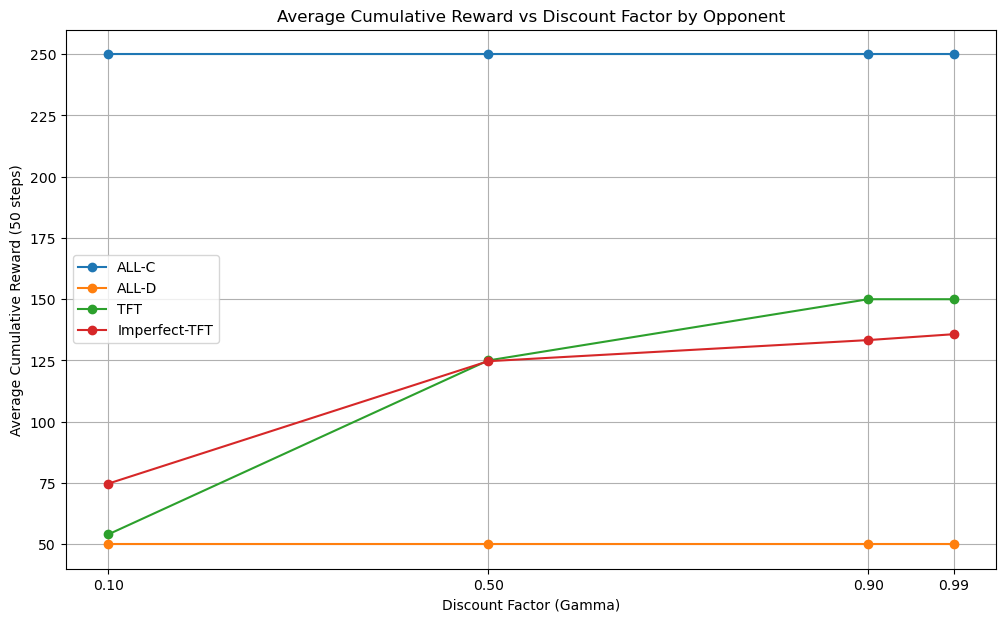

In [4]:
print("--- 1. Discount Factor Analysis ---")
gammas_to_test = [0.1, 0.5, 0.9, 0.99]
opponent_types = list(Strategy)
results = {opp.value: [] for opp in opponent_types}

for opp in opponent_types:
    for g in gammas_to_test:
        # Using Memory-1 as default
        env = RPDEnv(opponent_strategy=opp, memory_depth=1)
        P, R = env.get_mdp()
        policy, _ = policy_iteration(P, R, gamma=g)
        
        # Simulation
        total_reward = 0
        num_episodes = 50
        steps_per_episode = 50
        for _ in range(num_episodes):
            state_idx, _ = env.reset()
            for _ in range(steps_per_episode):
                action = policy[state_idx]
                next_state_idx, reward, _, _, _ = env.step(action)
                total_reward += reward
                state_idx = next_state_idx
        
        avg_reward = total_reward / num_episodes
        results[opp.value].append(avg_reward)
        print(f"Opponent: {opp.value}, Gamma: {g}, Avg Reward: {avg_reward:.2f}")

# Plotting
plt.figure(figsize=(12, 7))
for opp in opponent_types:
    plt.plot(gammas_to_test, results[opp.value], marker='o', label=opp.value)

plt.title('Average Cumulative Reward vs Discount Factor by Opponent')
plt.xlabel('Discount Factor (Gamma)')
plt.ylabel('Average Cumulative Reward (50 steps)')
plt.xticks(gammas_to_test)
plt.legend()
plt.grid(True)
plt.show()

## 5. Experiment 2: Memory Depth Comparison
We compare the performance of Memory-1 and Memory-2 agents against various opponents. We use a high discount factor ($\gamma=0.9$) to encourage cooperation.


--- 2. Memory Depth Analysis ---
Opponent: ALL-C
  Memory-1: 250.00
  Memory-2: 250.00
Opponent: ALL-D
  Memory-1: 50.00
  Memory-2: 50.00
Opponent: TFT
  Memory-1: 150.00
  Memory-2: 150.00
Opponent: Imperfect-TFT
  Memory-1: 133.56
  Memory-2: 134.46


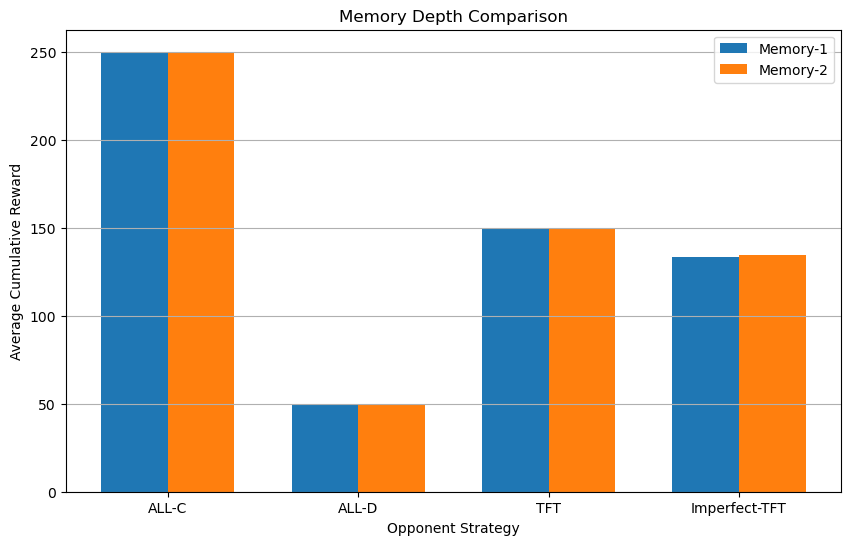

In [5]:
print("\n--- 2. Memory Depth Analysis ---")
gamma = 0.9
strategies = list(Strategy)
strategies_list = []
mem1_rewards = []
mem2_rewards = []

for strategy in strategies:
    strategies_list.append(strategy.value)
    rewards = {}
    for depth in [1, 2]:
        env = RPDEnv(opponent_strategy=strategy, memory_depth=depth)
        P, R = env.get_mdp()
        policy, _ = policy_iteration(P, R, gamma=gamma, states=env.states)
        
        # Simulation
        total_reward = 0
        for _ in range(50):
            state_idx, _ = env.reset()
            for _ in range(50):
                action = policy[state_idx]
                next_state_idx, reward, _, _, _ = env.step(action)
                total_reward += reward
                state_idx = next_state_idx
        rewards[depth] = total_reward / 50
    
    mem1_rewards.append(rewards[1])
    mem2_rewards.append(rewards[2])
    
    print(f"Opponent: {strategy.value}")
    print(f"  Memory-1: {rewards[1]:.2f}")
    print(f"  Memory-2: {rewards[2]:.2f}")

# Plot
x = np.arange(len(strategies_list))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mem1_rewards, width, label='Memory-1')
plt.bar(x + width/2, mem2_rewards, width, label='Memory-2')

plt.xlabel('Opponent Strategy')
plt.ylabel('Average Cumulative Reward')
plt.title('Memory Depth Comparison')
plt.xticks(x, strategies_list)
plt.legend()
plt.grid(axis='y')
plt.show()

## 6. Experiment 3: Noise Analysis
We analyze the impact of noise by comparing the optimal policy against a standard TFT opponent versus an Imperfect-TFT opponent (which has a 10% chance of error).

In [6]:
print("\n--- 3. Noise Analysis ---")
gamma = 0.9
for strategy in [Strategy.TFT, Strategy.IMPERFECT_TFT]:
    env = RPDEnv(opponent_strategy=strategy, memory_depth=1)
    P, R = env.get_mdp()
    policy, _ = policy_iteration(P, R, gamma=gamma, states=env.states)
    
    print(f"Strategy: {strategy.value}")
    print("Optimal Policy:")
    for s_idx, action in enumerate(policy):
        state = env.idx_to_state[s_idx]
        action_str = "C" if action == COOPERATE else "D"
        print(f"  State {state}: {action_str}")


--- 3. Noise Analysis ---
Strategy: TFT
Optimal Policy:
  State (0, 0): C
  State (0, 1): C
  State (1, 0): C
  State (1, 1): C
Strategy: Imperfect-TFT
Optimal Policy:
  State (0, 0): C
  State (0, 1): C
  State (1, 0): C
  State (1, 1): C
